# Olist E-commerce: 3 Actionable Insights for Business Growth

This notebook is a "client-friendly" demonstration of the 3 main insights from the [complete project (5 notebook pipeline)](https://github.com/Lucas-Ker/olist-data-analysis-project).

It does not run the full ETL; instead, it loads the processed data to showcase the key results in under 1 minute.

### The 3 Insights:

1.  **Logistics:** The problem is not the delivery time, it's the **broken promise**.

2.  **Retention:** 97% of customers make a single purchase (the "leaky bucket" model).

3.  **Forecasting:** It is possible to predict **68% of negative reviews** *before* they happen.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Visualization settings
plt.style.use('seaborn-v0_8-paper')
bright_colors = sns.color_palette('bright')

print("✅ Setup complete. Libraries imported.")

✅ Setup complete. Libraries imported.


In [2]:
# Load the data

try:
    df_analytics = pd.read_parquet('../data/analytics_main_data.parquet')
    df_rfm = pd.read_parquet('../data/rfm_data.parquet')
    df_model_results = pd.read_parquet('../data/classification_test_results.parquet')
    
    print("✅ Data loaded successfully:")
    print(f"   - Analytics data shape: {df_analytics.shape}")
    print(f"   - RFM data shape: {df_rfm.shape}")
    print(f"   - Model results shape: {df_model_results.shape}")

except FileNotFoundError:
    print("❌ ERROR: Data files not found.")
    print("Please ensure 'analytics_main_data.parquet', 'rfm_data.parquet',")
    print("and 'classification_test_results.parquet' are in the '../data/' folder.")

✅ Data loaded successfully:
   - Analytics data shape: (118310, 44)
   - RFM data shape: (95420, 9)
   - Model results shape: (22973, 2)


## Finding #1: The \#1 Driver of Bad Reviews Isn't Speed, It's the Broken Promise.

The statistical analysis (from notebook 02) proved that customers don't mind waiting as long as the promise is kept.

Orders that miss the estimated delivery date (even by 1 day) have an exponentially higher chance of receiving a rating of 1. The central issue is the **accuracy** of the estimate, not the **speed**.

/tmp/ipykernel_14847/924290185.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


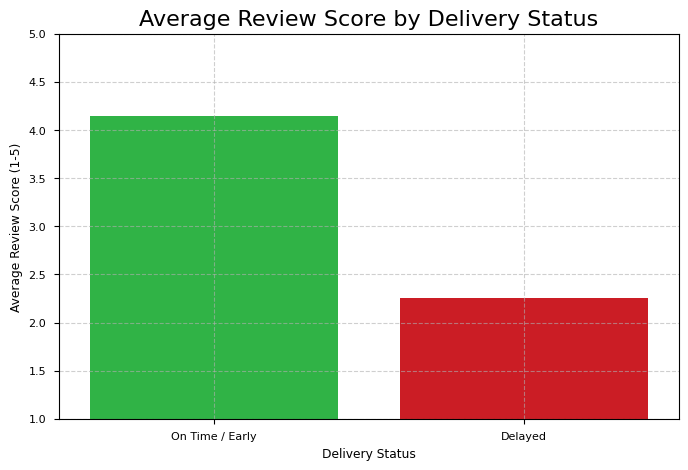


Insight: A nota média de reviews 'Atrasados' (Delayed) é drasticamente menor.


In [3]:
# 1. Map 'shipping_delay_days' for the 2 REAL categories of the data
def map_delivery_status(days):
    if days > 0:
        return 'Delayed'
    else:
        return 'On Time / Early'

df_analytics['delivery_status'] = df_analytics['shipping_delay_days'].apply(map_delivery_status)

# 2. Calculate the average rating by status
status_agg = df_analytics.groupby('delivery_status')['review_score'].mean().reset_index()


# 3. Plot the chart
plt.figure(figsize=(8, 5))
sns.barplot(
    data=status_agg,
    x='delivery_status',
    y='review_score',
    palette={'On Time / Early': bright_colors[2], 'Delayed': bright_colors[3]},
    order=['On Time / Early', 'Delayed']
)
plt.title('Average Review Score by Delivery Status', fontsize=16)
plt.xlabel('Delivery Status')
plt.ylabel('Average Review Score (1-5)')
plt.ylim(1, 5)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("\nInsight: A nota média de reviews 'Atrasados' (Delayed) é drasticamente menor.")

## Finding #2: Olist Has a 'Leaky Bucket' — 97% of Customers Buy Only Once.

The RFM (Recency, Frequency, Monetary) segmentation from notebook 03 revealed that the business model relies almost entirely on acquiring new customers, with virtually no loyalty.

The strategic challenge is not to increase the average ticket size, but to drive the **second purchase**.

In [4]:
# --- Insight #2 ---

# 1. Calculate the percentage of "one-time buyers" 
total_customers = df_rfm.shape[0]
one_time_buyers = (df_rfm['Frequency'] == 1).sum()
pct_one_time = (one_time_buyers / total_customers) * 100

print(f"Total Customers: {total_customers}")
print(f"One-Time Buyers: {one_time_buyers}")
print(f"Percentage of One-Time Buyers: {pct_one_time:.1f}%")
print("\n")


# 2. Apply the segmentation logic
# (Function from notebook 03)
def segment(row):
    r = int(row['R_score'])
    f = int(row['F_score'])
    
    if r >= 4 and f == 3:         
        return 'Champions'
    elif r >= 4 and f >= 2:       
        return 'Potential Loyalists'
    elif r >= 3 and f <= 2:
        return 'Need Attention'
    elif r <= 2 and f == 3:
        return 'At Risk'
    elif r <= 2 and f == 1:
        return 'Hibernating/Lost'
    else:
        return 'Others'

# Create the segment column in the loaded DataFrame
df_rfm['RFM_Segment'] = df_rfm.apply(segment, axis=1)


# 3. Show the RFM segments
print("--- The Segmentation (The Strategy) ---")
print("Customer distribution by segment:")
print(df_rfm['RFM_Segment'].value_counts(normalize=True) * 100)



Total Customers: 95420
One-Time Buyers: 92507
Percentage of One-Time Buyers: 96.9%


--- The Segmentation (The Strategy) ---
Customer distribution by segment:
RFM_Segment
Need Attention         58.700482
Hibernating/Lost       38.862922
Potential Loyalists     1.178998
Others                  1.044854
Champions               0.137288
At Risk                 0.075456
Name: proportion, dtype: float64


## Finding #3: We Can Proactively Find 68% of Unhappy Customers.

A Random Forest model (from notebook 04) was successfully built to predict which orders are highly likely to receive a rating of 1 or 2.

This model achieves **68% Recall**, allowing a Customer Service team to intervene *before* the bad review is written.

--- Model Performance (Random Forest) ---
Target: Predict 'Bad Reviews' (Class 1)
✅ Model Recall: 68.1%
(The model found 68% of all actual bad reviews in the test set.)


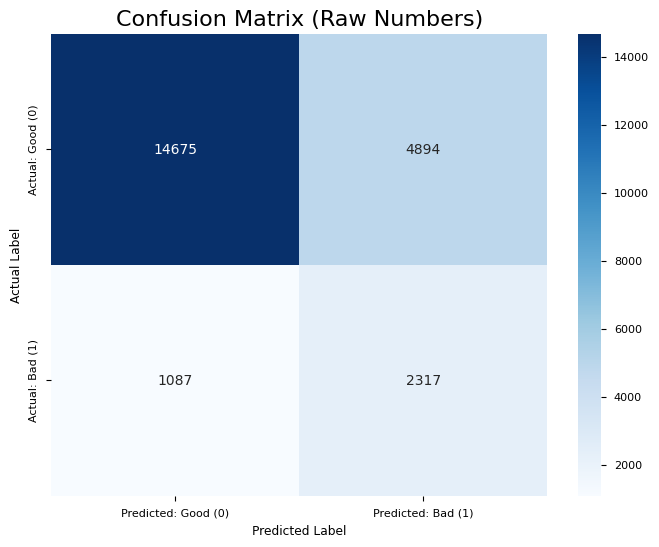

In [5]:
# This cell loads the *results* of the model (from notebook 04)
# and plots the Confusion Matrix

# Extract the true (y_test) and predicted (y_pred) columns
y_true = df_model_results['y_test']
y_pred = df_model_results['rf_pred'] 

# 1. Calculate the Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_normalized = confusion_matrix(y_true, y_pred, normalize='true')

# 2. Extract the Recall (True Positives for class "Bad" = 1)
# Remember, Recall is the value on the diagonal of the normalized matrix
recall = cm_normalized[1, 1] 

print(f"--- Model Performance (Random Forest) ---")
print(f"Target: Predict 'Bad Reviews' (Class 1)")
print(f"✅ Model Recall: {recall:.1%}")
print(f"(The model found {recall*100:.0f}% of all actual bad reviews in the test set.)")

# 3. Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted: Good (0)', 'Predicted: Bad (1)'], 
            yticklabels=['Actual: Good (0)', 'Actual: Bad (1)'])
plt.title('Confusion Matrix (Raw Numbers)', fontsize=16)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

## Conclusion & Next Steps

With these 3 insights, a company can:

1.  **Act Proactively:** Use the ML model to reach out to customers with a high chance of leaving a bad review.

2.  **Focus on Retention:** Create marketing campaigns for the "At Risk" RFM segments.

3.  **Improve Logistics:** Focus on *accuracy of estimates* rather than speed.

---

Interested in a similar analysis for *your* business?
* **See the full project:** [https://github.com/Lucas-Ker/olist-data-analysis-project](https://github.com/Lucas-Ker/olist-data-analysis-project)

* **Invite me on Upwork:** [Your Upwork Link]()